In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler

from math import ceil

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop


In [3]:
sale = pd.read_csv('fusai_data/goodsale.csv')
sale['data_date'] = pd.to_datetime(sale['data_date'], format='%Y%m%d')

/Users/bb/opt/anaconda3/envs/atd2020/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [20]:
sale['data_date'].max()

Timestamp('2018-03-16 00:00:00')

# sales-time

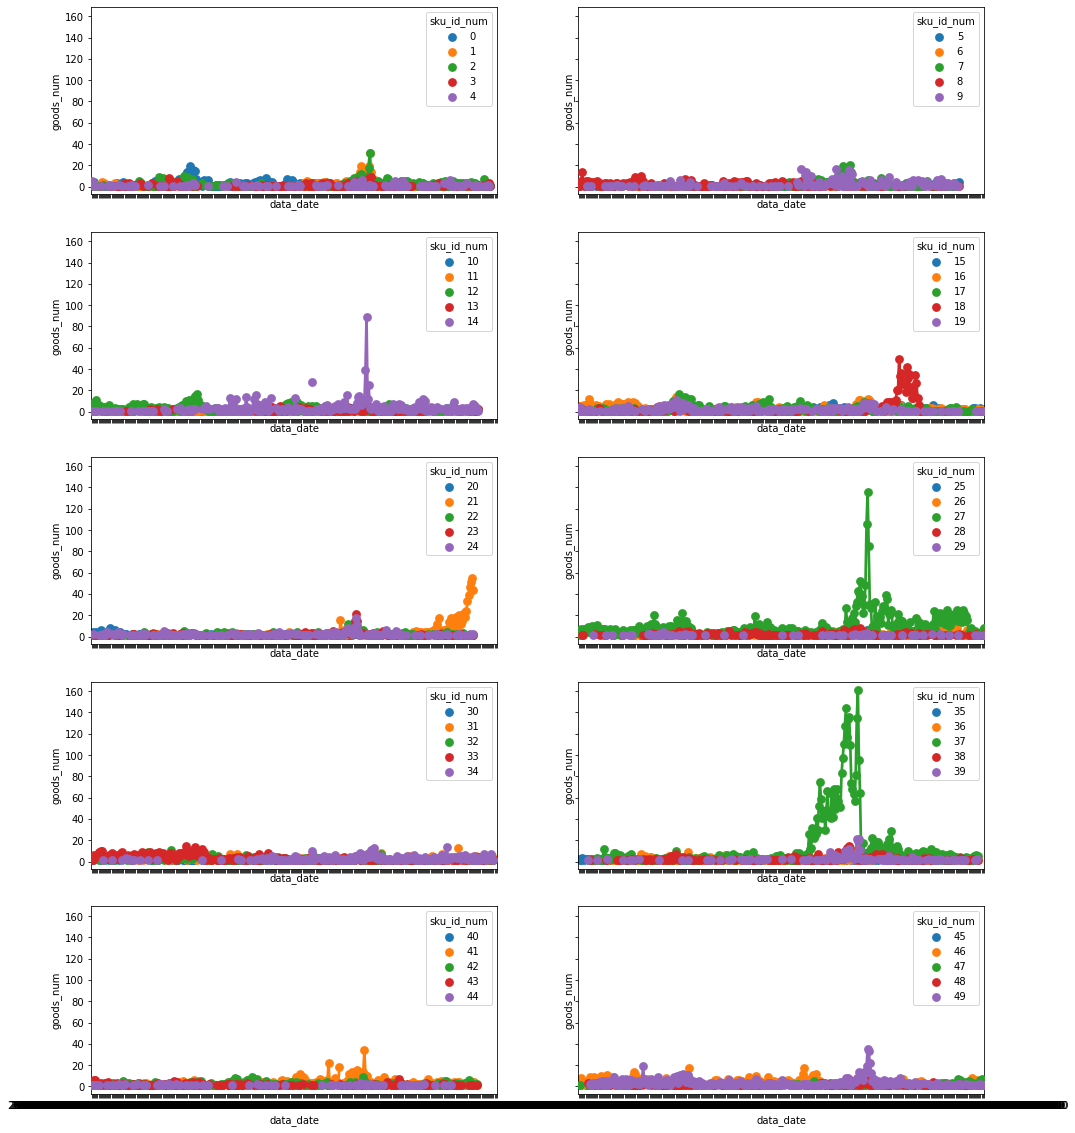

In [13]:
sale["sku_id_num"] = pd.factorize(sale["sku_id"])[0].astype(np.uint16)
grouped = pd.DataFrame(sale.groupby(['sku_id_num', 'data_date'])['goods_num'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
num_graph = 10
id_per_graph = ceil(5)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='data_date', y='goods_num', hue='sku_id_num', data=grouped[np.logical_and(count*id_per_graph <= grouped['sku_id_num'], grouped['sku_id_num'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

# sale of sku_id

In [34]:
sale

,data_date,goods_id,sku_id,goods_num,goods_price,orginal_shop_price,sku_id_num
0,2017-05-18,GIxOHa,SKg8D0d7,1,1.99,1.99,0
1,2017-11-30,GrXpTc,SKq3pF8j,6,29.99,37.99,1
2,2017-10-19,G3ORTV,SKIwiWXl,1,6.99,11.99,2
3,2017-05-31,GDRp2b,SKRNl1oL,1,16.99,21.99,3
4,2017-06-10,GHulZo,SKtD5qKW,1,5.99,5.99,4
...,...,...,...,...,...,...,...
12918274,2017-07-07,Gj7VIq,SKDVvB5b,2,11.99,21.99,39485
12918275,2017-12-24,Gf0MHX,SKTfz6mL,2,26.49,45.99,12275
12918276,2017-11-21,GLonSQ,SKt4jxGp,1,10.99,19.99,49667
12918277,2017-06-19,GdKSGI,SKTU3S5V,4,7.99,13.99,7396


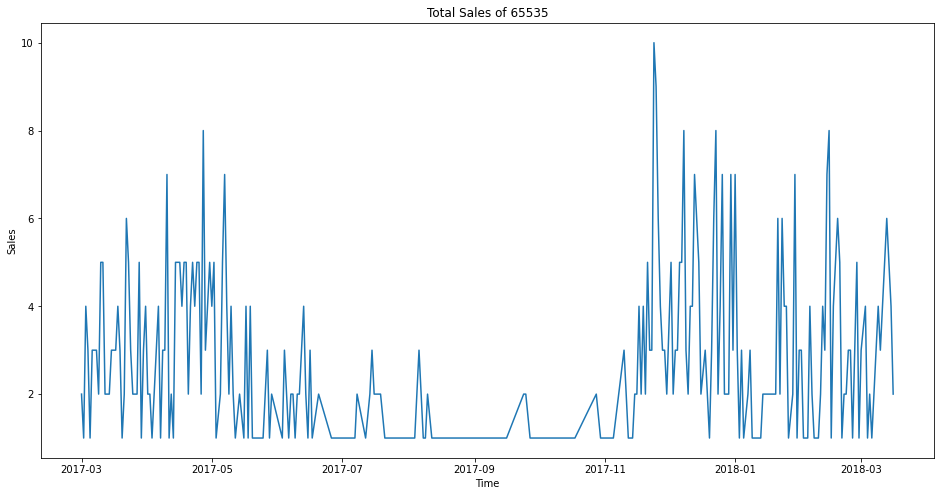

In [31]:
sale_SKg8D0d7 = sale[sale['sku_id_num']==65535]
ts=sale_SKg8D0d7.groupby(["data_date"])["goods_num"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title("Total Sales of 65535")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)


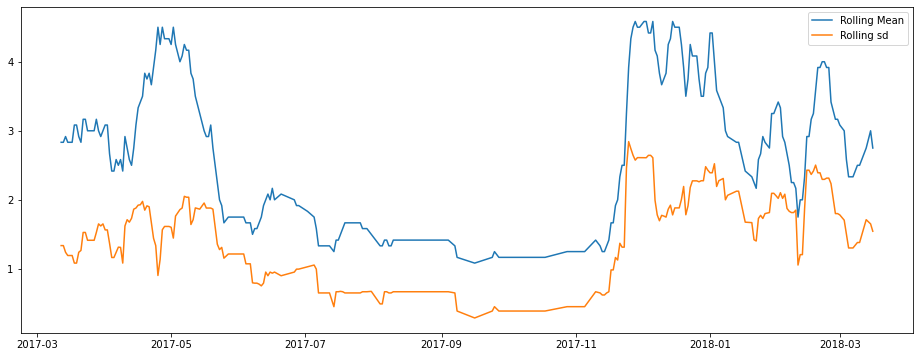

In [32]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

In [55]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# multiplicative
def create_date_tick(df):
    '''
    Converts dates from this format: Timestamp('1949-01-01 00:00:00')
    To this format: 'Jan-1949'
    '''
    df["date"] = pd.to_datetime(df["data_date"]) # convert to datetime
    #df.set_index("date", inplace = True)
    df["month_name"] = df["date"].dt.month_name() # extracts month_name
    df["month_name"] = df["month_name"].apply(lambda x: x[:3]) # passes from January to Jan
    df["year"] = df["date"].dt.year # extracts year
    df["new_date"] = df["month_name"].astype(str) + "-" +df["year"].astype(str) # Concatenaes Jan and year --> Jan-1949
    return df

# create the time column and the xtickslabels column    
#ts = ts.reset_index()
ts=sale_SKg8D0d7.groupby(["data_date"])["goods_num"].sum()
ts = pd.DataFrame(ts).reset_index()
ts = create_date_tick(ts)

# decompose the series using stats module
# results in this case is a special class 
# whose attributes we can acess


ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [75]:
ts=sale_SKg8D0d7.groupby(["data_date"])["goods_num"].sum()
ts = pd.DataFrame(ts)
ts.sort_index(inplace= True)
result = seasonal_decompose(ts["goods_num"])

# ----------------------------------------------------------------------------------------------------
# instanciate the figure
# make the subplots share teh x axis
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize = (12,10))
result.observed.plot(ax = axes[0], legend = False)
axes[0].set_ylabel('Observed')
axes[0].set_title("Decomposition of a series")

# plot the trend
result.trend.plot(ax = axes[1], legend = False)
axes[1].set_ylabel('Trend')

# plot the seasonal part
result.seasonal.plot(ax = axes[2], legend = False)
axes[2].set_ylabel('Seasonal')

# plot the residual
result.resid.plot(ax = axes[3], legend = False)
axes[3].set_ylabel('Residual')

# ----------------------------------------------------------------------------------------------------
# prettify the plot

# get the xticks and the xticks labels
xtick_location = ts.index.tolist()[::6]
xtick_labels = ts["new_date"].tolist()[::6]

# set the xticks to be every 6'th entry
# every 6 months
ax.set_xticks(xtick_location)

# chage the label from '1949-01-01 00:00:00' to this 'Jan-1949'
ax.set_xticklabels(xtick_labels, rotation=90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [74]:
ts